# Wage dataset

This notebook filters out the SLID (Survey of Labour Income and Dynamics) to produce the dataset for the wage model 

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)

In [2]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

## 1. Auxiliary functions

In [3]:
# Define a function to adjust monetary values with the CPI
def adjust_cpi(
    data: pd.DataFrame,
    adj_col: str,
    year_col: str,
    month_col: str = None,
    base_year: int = 2023,
    base_month: int = None,
    geo: str = "Toronto",
) -> pd.Series:
    """
    Function to adjust a monetary value ($CAD) to the base year using CPI data

    Parameters
    ----------
    data : pd.DataFrame
        DataFrame containing the monetary values to be adjusted

    adj_col : str
        Column name of the monetary values to be adjusted

    year_col : str or int
        Column name or integer containing the year of the monetary values to be adjusted

    month_col : str or int, optional
        Column name or integer containing the month of the monetary values to be adjusted, by default None

    base_year : int, optional
        Base year to adjust the values to, by default 2023
        Options are integers between 1987 and 2023

    base_month : int, optional
        Base month to adjust the values to, by default None
        Options are integers between 1 and 12, or None for annual adjustment

    geo : str, optional
        Geography to use for CPI data, by default 'Toronto'.
        Options are {'Canada','Ontario','Toronto'}
    """

    # Load CPI data - Local
    cpi = pd.read_csv("../../../Data/cpi1987_2023.csv")

    # # Load CPI data - GCP
    # cpi = pd.read_csv("/home/adcastillove/pymc/cpi1987_2023.csv")

    # Define columns of interest
    if month_col is None:
        cols = [year_col, adj_col]
        merge_cols = [year_col, "month"]
    else:
        cols = [year_col, month_col, adj_col]
        merge_cols = [year_col, month_col]

    # Copy the data (only columns of interest)
    adj_data = data[cols].copy()

    # Annual adjustment (if months is not provided)
    # NOTE: If months are not provided, the CPI indexing is done on an annual basis (as reference to December of each year)
    if month_col is None:
        adj_data["month"] = 12
        base_month = 12

    # Calculate base CPI (for the base_year and base_month)
    base_index = cpi[(cpi["geo"] == geo)\
                     & (cpi["year"] == base_year)\
                     & (cpi["month"] == base_month)]["value"].to_list()[0]
    
    # Merge the CPI data with the data
    adj_data = adj_data.merge(
        cpi[cpi["geo"] == geo],
        left_on=merge_cols,
        right_on=["year", "month"],
        how="left",
    )

    # Calculate the adjusted values
    adj_data[f"{adj_col}"] = adj_data[adj_col] * base_index / adj_data["value"]

    return adj_data[f"{adj_col}"]

In [4]:
def plot_posterior_pred_check(var_obj, ndata, nchains, ndraws, infer_data, n_samples=100):
    """Plot posterior predictive check for a given variable and compare it with the observed data distribution"""
    posterior_dist = np.sort(infer_data.posterior_predictive[f"{var_obj}"].values, axis=2).mean(axis=(0,1))

    observed = infer_data.observed_data[f"{var_obj}"].values

    posterior_samples = infer_data.posterior_predictive[f"{var_obj}"].values.reshape(nchains * ndraws, ndata)
    posterior_samples = posterior_samples[np.random.choice(posterior_samples.shape[0], n_samples, replace=False), :]

    fig, ax = plt.subplots()

    for i, sample in enumerate(posterior_samples):
        if i == n_samples - 1:
            sns.kdeplot(sample, ax=ax, color='grey', alpha=0.2, label='posterior pred')
        else:
            sns.kdeplot(sample, ax=ax, color='grey', alpha=0.05)

    sns.kdeplot(observed, label='wage', ax=ax, color='C0')
    sns.kdeplot(posterior_dist, label=f'{var_obj} (mean post. pred)', ax=ax, color='C1')
    
    ax.legend(loc='upper right', fontsize=11);
    ax.set_title(f"Posterior predictive check - {var_obj}", fontweight="bold");
    ax.set_xlabel("Wage ($CAD)", fontsize=11);
    ax.set_ylabel("Density", fontsize=11);

    # Set x-axis limits
    ax.set_xlim(0, 0.6e6);

    # Adjust axis ticks font size
    ax.tick_params(axis="both", labelsize=11);

## 2. Import data

In [14]:
# Local env
slid = pd.read_parquet('../../../Data/Survey of Labour and Income Dynamics (SLID)/compilates/slid_personal_std.parquet')

# GCP env
# slid = pd.read_parquet('/home/adcastillove/pymc/slid_personal_std.parquet')

In [15]:
# Filter out relevant columns from the original dataset
data = slid[["YEAR","YRXFTE11","WGSAL42","ALFST28","WEIGHT","ECAGE26","FLLPRT1","HLEVEG18","ECSEX99","NAI3G10","NOCG2E6",
             "ML01V28","ML02V28","ML03V28","ML04V28","ML05V28","ML06V28","ML07V28","ML08V28","ML09V28","ML10V28","ML11V28","ML12V28",
             "FSEIN28","FSEUI28","FPDWK28","TOTHRP1","TTINC42","EARNG42","SEMP42","OTTXM42","MTINC42","MAJRI42","MJACG26","IMPHWE1",
             "UNCOLL1","STUDTF26","REAWPT1","RCUNIV20","RCCOLL20","PUBPV10","NBJBS28","NBEMA10","NBEMPL1","MULTJ28","MTLSWK28",
             "JOBDUR1","FLLPRT20","CLWKR1","CMPHI20"]].reset_index(drop=True).copy()


## 3. Processing data

In this section, some transofrmations are applied to the original dataset and some features are created.

***NOTE: Cleaning the hours paid and hourly wage could be useful in the transitions model or the work hours model. Test dropping rows with outliers in the hourly wage (calculated with hourly_wage column or dividing salary by the hours_paid) by compare them with the minimum wage in that year (adjusted by the CPI)***

In [16]:
# Rename columns
data = data.rename(columns={
    "YEAR": "year",
    "YRXFTE11": "exp",
    "WGSAL42": "salary",
    "ALFST28": "lfs",
    "WEIGHT": "weight",
    "ECAGE26": "age",
    "FLLPRT1": "ftpt",
    "HLEVEG18": "edu",
    "ECSEX99": "sex",
    "NAI3G10": "industry",
    "NOCG2E6": "occup",
    "ML01V28": "lab_status_01",
    "ML02V28": "lab_status_02",
    "ML03V28": "lab_status_03",
    "ML04V28": "lab_status_04",
    "ML05V28": "lab_status_05",
    "ML06V28": "lab_status_06",
    "ML07V28": "lab_status_07",
    "ML08V28": "lab_status_08",
    "ML09V28": "lab_status_09",
    "ML10V28": "lab_status_10",
    "ML11V28": "lab_status_11",
    "ML12V28": "lab_status_12",
    "FSEIN28": "self_inc",
    "FSEUI28": "self_uninc",
    "FPDWK28": "paid_work",
    "TOTHRP1": "hours_paid",
    "TTINC42": "total_inc",
    "EARNG42": "earnings",
    "SEMP42": "self_emp_inc",
    "OTTXM42": "other_inc",
    "MTINC42": "market_inc",
    "MAJRI42": "major_source_inc",
    "MJACG26" : "major_activity",
    "IMPHWE1": "hourly_wage",
    "UNCOLL1": "union",
    "STUDTF26": "student_status",
    "REAWPT1": "reason_pt",
    "CMPHI20": "grad_highschool_refyear",
    "RCCOLL20": "grad_college_refyear",
    "RCUNIV20": "grad_univ_refyear",
    "PUBPV10": "employment_sector",
    "NBJBS28": "num_jobs",
    "NBEMA10": "firm_size",
    "NBEMPL1": "loc_size",
    "MULTJ28": "multiple_jobs",
    "MTLSWK28": "months_last_worked",
    "JOBDUR1": "tenure",
    "FLLPRT20": "student_status_2",
    "CLWKR1": "class_worker",
    })

### Dataset preparation: 
# Adjust wages using base year cpi
data["salary"] = adjust_cpi(data=data, adj_col="salary", year_col="year", base_year=2022, geo="Toronto")

# Adjust hourly wage using base year cpi
data["hourly_wage"] = adjust_cpi(data=data, adj_col="hourly_wage", year_col="year", base_year=2022, geo="Toronto")

# Create employed flag-column (indicated if the person was employeed any time for the reference year)
data["employed"] = ~(data["lfs"].isin([None, "not in the labour force all year", "unemployed all year",
                                       "unemployed part-year, not in labour force part-year"])) * 1

# Count the number of months where == employed
employment_status_cols = ["lab_status_01",
                          "lab_status_02",
                          "lab_status_03",
                          "lab_status_04",
                          "lab_status_05",
                          "lab_status_06",
                          "lab_status_07",
                          "lab_status_08",
                          "lab_status_09",
                          "lab_status_10",
                          "lab_status_11",
                          "lab_status_12"]
data["months_emp"] = data[employment_status_cols].apply(lambda x: (x == "employed") * 1).sum(axis=1)
data.drop(columns=employment_status_cols, inplace=True)

# Create self-employed flag-column (indicated if the person was self-employed any time for the reference year)
data["self_emp"] = ((data["self_inc"] == "yes") | (data["self_uninc"] == "yes")) * 1

# Convert age to float
data["age"] = data["age"].replace("80+", 80).astype(float)

# Change category order and get one-hot encoding for sex
data["sex"] = data["sex"].cat.reorder_categories(["Male", "Female"])
data["sex"] = pd.get_dummies(data["sex"], drop_first=True) * 1

# Convert education level to one-hot encoding corresponding to the highest level of education achieved (with certificate)
## NOTE: The encoding assumes that the education level is cumulative. e.g. if the person has a bachelor's degree, it is assumed that the person
## has also completed high school and elementary school. However, for university levels (bachelors and above), it is assumed that the person
## has not completed a post-secondary certificate (e.g. college certificate).
data["elementary_edu"] = (data["edu"] >= '5-8 years of elementary school') * 1
data["highschool_edu"] = (data["edu"] >= 'graduated high school') * 1
data["postsec_edu"] = ((data["edu"] == 'non-university postsecondary certificate') | (data["edu"] == 'university certificate below bachelor')) * 1
data["undergrad_edu"] = (data["edu"] >= "bachelor's degree") * 1
data["graduate_edu"] = (data["edu"] >= 'university certificate above bachelor') * 1

# Create education level column for the hierarchical model
data["edu_level"] = ((data["edu"] < "5-8 years of elementary school") * 1) + (((data["edu"] >= "5-8 years of elementary school") & (data["edu"] < "graduated high school")) * 2) +\
                    (((data["edu"] >= "graduated high school") & (data["edu"] < "non-university postsecondary certificate")) * 3) +\
                    (((data["edu"] >= "non-university postsecondary certificate") & (data["edu"] < "bachelor's degree")) * 4) +\
                    (((data["edu"] >= "bachelor's degree") & (data["edu"] < "university certificate above bachelor")) * 5) +\
                    ((data["edu"] >= "university certificate above bachelor") * 6)

# Convert union status to one-hot encoding
data["union"] = ~(data["union"].isin(["no",None])) * 1

# Convert student status to one-hot encoding
data["student_status"] = (data["student_status"] == "yes") * 1

# Convert graduation from high school, college, or university to one-hot encoding
data["grad_highschool_refyear"] = (data["grad_highschool_refyear"] == "yes") * 1
data["grad_college_refyear"] = (data["grad_college_refyear"] == "yes") * 1
data["grad_univ_refyear"] = (data["grad_univ_refyear"] == "yes") * 1

# Convert employment sector to one-hot encoding
data["public_sector"] = (data["employment_sector"] == "public sector") * 1
data["private_sector"] = (data["employment_sector"] == "private sector") * 1

# Convert multiple jobs holder to one-hot encoding
data["multiple_jobs"] = (data["multiple_jobs"] == "yes") * 1

# Convert firm size to categorical
data = data.dropna(subset=["firm_size"])
data["firm_size"] = pd.factorize(data["firm_size"])[0]

# Convert location size to categorical
data = data.dropna(subset=["loc_size"])
data["loc_size"] = pd.factorize(data["loc_size"])[0]

# Convert full-time/part-time status to one-hot encoding
data["part_time"] = (data["ftpt"] == "part-time") * 1

In [17]:
# # Drop NaNs
data = data.dropna(subset=["exp"])
data = data.dropna(subset=["tenure"])

# # Filter data
data = data[(data["salary"]>0)\
          & (data["major_activity"]=="working")\
          & (data["paid_work"]=="yes")\
          & (data["major_source_inc"]=="wages and salaries")
        ]

# ### This is the full dataset (all columns)
# data = data[['total_inc', 'grad_highschool_refyear', 'other_inc', 'employment_sector', 'edu_level', 'lfs', 'occup',
#   'elementary_edu', 'major_activity', 'public_sector', 'self_uninc', 'highschool_edu', 'months_last_worked',
#   'industry', 'self_inc', 'hours_paid', 'self_emp_inc', 'loc_size', 'age', 'tenure', 'grad_college_refyear', 'market_inc',
#    'year', 'weight', 'grad_univ_refyear', 'salary', 'graduate_edu', 'union', 'student_status',
#   'class_worker', 'postsec_edu', 'firm_size', 'undergrad_edu', 'paid_work', 'student_status_2', 'major_source_inc', 'num_jobs',
#   'multiple_jobs', 'ftpt', 'self_emp', 'exp', 'earnings', 'reason_pt', 'edu', 'hourly_wage', 'sex']].copy()

### THis is a subset of the columns of interest
data = data[['edu','edu_level','elementary_edu','highschool_edu','postsec_edu','undergrad_edu','graduate_edu',
             'grad_highschool_refyear','grad_college_refyear','grad_univ_refyear','student_status',
             'public_sector','private_sector','lfs','occup','industry','self_emp','union','part_time','major_activity',
             'major_source_inc','multiple_jobs','num_jobs','exp','reason_pt','hourly_wage','hours_paid',
             'months_last_worked','tenure','sex','age','year','weight','salary','firm_size','loc_size']].copy()

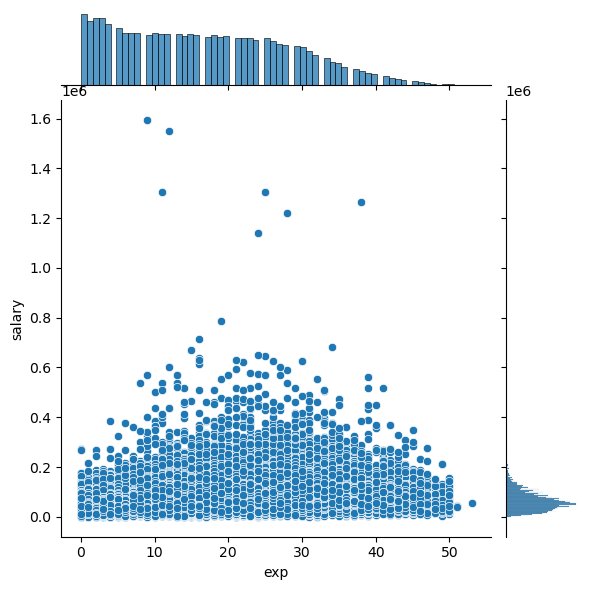

In [18]:
sns.jointplot(data=data, x="exp", y="salary", kind="scatter");

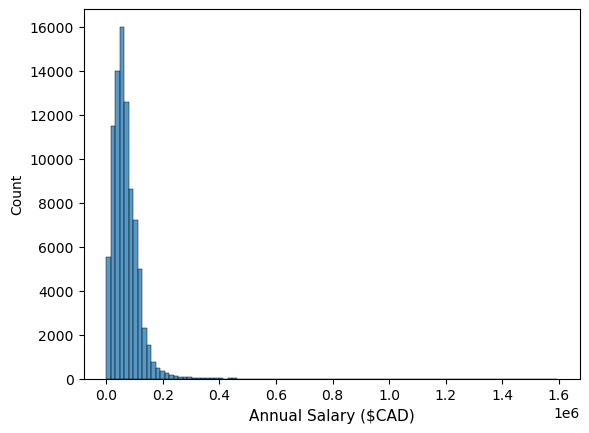

In [19]:
sns.histplot(data=data, x="salary", bins=100);

plt.xlabel("Annual Salary ($CAD)", fontsize=11);

## Export dataset

In [24]:
data.to_csv("../datasets/model_dataset.csv")